# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Activation, Input, Conv2D, Conv2DTranspose, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from keras import backend
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.models import Model
from tensorflow.keras import losses
from sklearn.metrics import confusion_matrix
from percolation import read_percolation_data
from sklearn.model_selection import train_test_split
import sys

# Loading Data

In [2]:
L = 128
pc = 0.59274
#p_arr = np.round(np.arange(0, 1.0, 0.01), 4)
#p_arr = np.round(np.array([0.57, 0.58, 0.61, 0.62]), 4)
p_arr = np.round(np.array([0.2 , 0.9]), 4)
p_arr = np.append(p_arr, pc)

In [17]:
X, y = read_percolation_data(L, p_arr, pc, max_configs_per_p=1000)

In [18]:
print(X.shape, y.shape)

(3000, 128, 128, 1) (3000,)


In [19]:
N = X.shape[0]
L = X.shape[1] 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [21]:
print('X.shape:', X.shape, ', y.shape:', y.shape)
print('X_train.shape:', X_train.shape, ', y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape, ', y_test.shape:', y_test.shape)

X.shape: (3000, 128, 128, 1) , y.shape: (3000,)
X_train.shape: (2400, 128, 128, 1) , y_train.shape: (2400,)
X_test.shape: (600, 128, 128, 1) , y_test.shape: (600,)


In [22]:
# number of classes
K = len(set(y_train))
print("number of classes:", K)

number of classes: 2


# Defining and training the AutoEncoder

In [23]:
latent_space_dimension = 10

In [38]:
def custom_activation(x):
    return (backend.sigmoid(x) * 2) - 1

In [39]:
class AutoEncoder(Model):
  def __init__(self, L, latent_space_dimension):
    super(AutoEncoder, self).__init__()
    
    self.encoder = tf.keras.Sequential([
      Input(shape=(L, L, 1)), 
      Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
      BatchNormalization(),
      Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
      BatchNormalization(),
      Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
      BatchNormalization(),
      Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
      BatchNormalization(),
      Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
      BatchNormalization(),
      Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
      BatchNormalization(),
      Conv2D(latent_space_dimension, (3,3), activation='relu', padding='same', strides=2),
      BatchNormalization()])
    
    self.decoder = tf.keras.Sequential([
      Conv2DTranspose(latent_space_dimension, kernel_size=3, strides=2, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2D(1, kernel_size=(3,3), activation=custom_activation, padding='same')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [40]:
autoencoder = AutoEncoder(L, latent_space_dimension)

In [41]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [42]:
r = autoencoder.fit(X_train, X_train, epochs=15, validation_data=(X_test, X_test))

Epoch 1/15
75/75 [==============================] - 54s 721ms/step - loss: 0.7999 - val_loss: 0.9713
Epoch 2/15
75/75 [==============================] - 56s 743ms/step - loss: 0.6702 - val_loss: 0.9755
Epoch 3/15
75/75 [==============================] - 55s 736ms/step - loss: 0.6670 - val_loss: 0.9646
Epoch 4/15
75/75 [==============================] - 54s 726ms/step - loss: 0.6628 - val_loss: 0.8918
Epoch 5/15
75/75 [==============================] - 54s 723ms/step - loss: 0.6652 - val_loss: 0.6755
Epoch 6/15
75/75 [==============================] - 54s 726ms/step - loss: 0.6665 - val_loss: 0.6477
Epoch 7/15
75/75 [==============================] - 54s 723ms/step - loss: 0.6665 - val_loss: 0.6486
Epoch 8/15
75/75 [==============================] - 55s 729ms/step - loss: 0.6635 - val_loss: 0.6507
Epoch 9/15
75/75 [==============================] - 55s 730ms/step - loss: 0.6626 - val_loss: 0.6499
Epoch 10/15
75/75 [==============================] - 56s 749ms/step - loss: 0.6630 - val_lo

In [43]:
autoencoder.encoder.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_56 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_57 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_58 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 8, 8, 64)         

In [44]:
autoencoder.decoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_28 (Conv2DT (None, 2, 2, 10)          910       
_________________________________________________________________
batch_normalization_63 (Batc (None, 2, 2, 10)          40        
_________________________________________________________________
conv2d_transpose_29 (Conv2DT (None, 4, 4, 128)         11648     
_________________________________________________________________
batch_normalization_64 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
conv2d_transpose_30 (Conv2DT (None, 8, 8, 128)         147584    
_________________________________________________________________
batch_normalization_65 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_transpose_31 (Conv2DT (None, 16, 16, 64)       

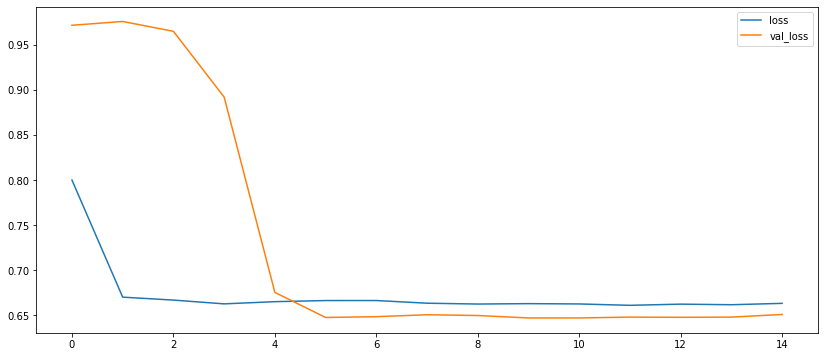

In [45]:
plt.figure(figsize=(14,6))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [49]:
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [47]:
encoded_imgs = autoencoder.encoder([X[0], X[-1]]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

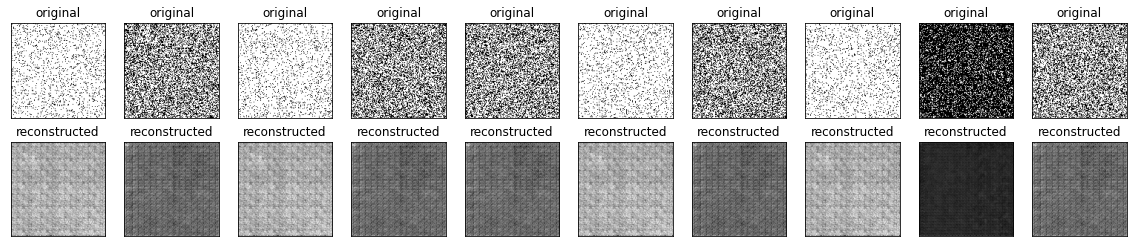

In [50]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(X_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()